In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Copy all the files to a local directory, because I don't have the right permissions on RDSF

"""
import os
import yaml
import shutil
import pathlib
from tqdm import tqdm

# Create an output file directory
battery_dir = "data/battery_dbs/"
if not os.path.isdir(battery_dir):
    os.makedirs(battery_dir)

# Find all the files
with open("config.yaml", "r") as stream:
    dirname = "/mnt/z/" + yaml.safe_load(stream)["smartwatch_dbs_dir"]
dirname = pathlib.Path(dirname)
assert dirname.exists()

# Recurse into all "Week X" directories, extracting all .db files
source_files = [file for file in dirname.glob("Week*/**/*.db")]
dest_files = [os.path.join(battery_dir, file.name) for file in source_files]

# Check that they don't all exist
if not all([os.path.isfile(dest) for dest in dest_files]):
    for source, dest in tqdm(zip(source_files, dest_files), total=len(source_files)):
        assert not os.path.isfile(dest), f"Duplicate name {source}"
        shutil.copyfile(source, dest)

In [3]:
"""
Create a csv of p_id, timestamp and battery level

"""
import sqlite3
import pandas as pd


dfs = []

for path in tqdm(dest_files):
    # Get the p_id from the path
    path = pathlib.Path(path)
    p_id = path.name.split("_")[1]

    # Open the db
    conn = sqlite3.connect(path, uri=True)

    # Get the battery level
    try:
        df = pd.read_sql_query("SELECT * FROM Event;", conn)

    except pd.io.sql.DatabaseError as e:
        print(f"{path} failed with {e}")
        continue

    # Only keep battery level rows
    df = df[df["eventdesc"].str.startswith("B")]

    # Add a new column for timestamp
    df["Datetime"] = pd.to_datetime(
        df["eventdate"] + " " + df["eventtime"], format="%Y-%m-%d %H:%M:%S"
    )
    df["battery_lvl"] = df["eventdesc"].str.split(" ").str[-1].str[:-1].astype(int)

    df["p_id"] = p_id

    dfs.append(df[["p_id", "Datetime", "battery_lvl"]])

    conn.close()

battery_level_df = pd.concat(dfs)
battery_level_df.head()

100%|██████████| 77/77 [00:00<00:00, 384.96it/s]

data/battery_dbs/EMADATA_15082_20220420.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_20050_20220412.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_29061_20220628.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_4260_20211221.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_27345_20220615.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_35272_20220520.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_3017_20220204.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_23532_20220204.db failed 

,p_id,Datetime,battery_lvl
2,765,2022-04-12 12:56:52,22
5,765,2022-04-12 12:59:06,25
8,765,2022-04-12 14:01:50,99
12,765,2022-04-12 16:31:37,100
15,765,2022-04-12 17:32:11,99


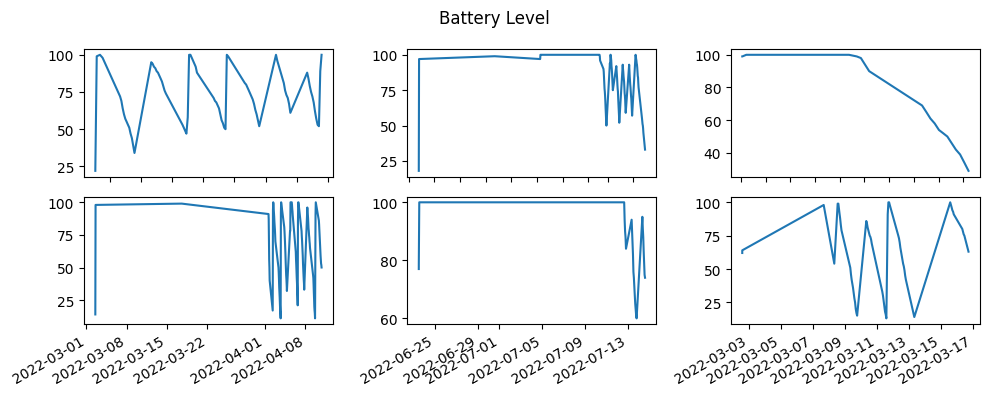

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(10, 4))

for pid, axis in zip(battery_level_df["p_id"].unique(), axes.flat):
    slice_ = battery_level_df[battery_level_df["p_id"] == pid].sort_values("Datetime")
    axis.plot(slice_["Datetime"], slice_["battery_lvl"], "-")

fig.suptitle("Battery Level")

fig.autofmt_xdate()
fig.tight_layout()

imgdir = "img/battery_level"
if not os.path.isdir(imgdir):
    os.makedirs(imgdir)
fig.savefig(f"{imgdir}/battery_level.png")

In [5]:
"""
Find the start day of each participant

"""
from ema import read

battery_df = battery_level_df.copy()
battery_df["p_id"] = battery_df["p_id"].astype(int)
battery_df = battery_df.set_index(battery_df["Datetime"]).drop(columns=["Datetime"])

battery_df = read.add_timedelta(battery_df)
len(battery_df)

5879

In [6]:
"""
Remove negative delta and deltas above 7

"""
battery_df = battery_df[battery_df["delta"].dt.days >= 0]
battery_df = battery_df[battery_df["delta"].dt.days <= 7]
len(battery_df)

4974

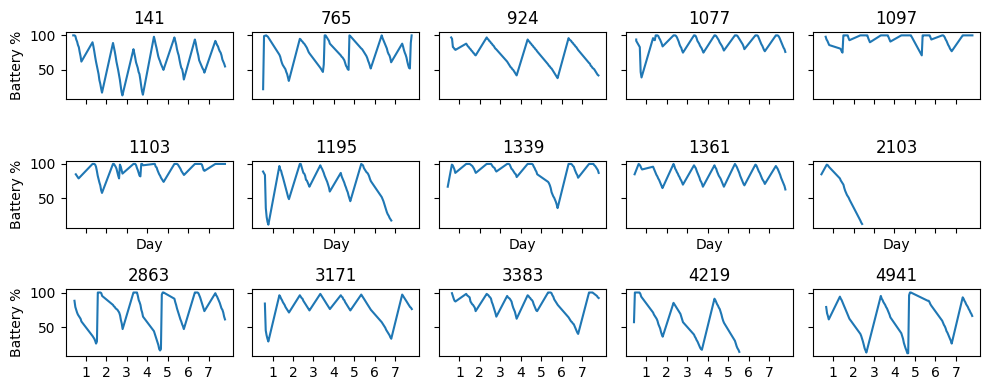

In [7]:
"""
Plot battery level against delta

"""
from itertools import islice
import numpy as np

fig, axes = plt.subplots(3, 5, figsize=(10, 4), sharex=True, sharey=True)

for axis, (p_id, grp) in zip(
    axes.flat, islice(battery_df.groupby("p_id"), len(axes.flat))
):
    axis.plot(grp["delta"].dt.total_seconds(), grp["battery_lvl"])
    axis.set_title(p_id)

for axis in axes[:, 0]:
    axis.set_ylabel("Battery %")
for axis in axes[1]:
    axis.set_xlabel("Day")

# Convert x labels to days
axis.set_xticks(np.arange(1, 8) * 24 * 3600, range(1, 8))

fig.tight_layout()
fig.savefig(f"{imgdir}/battery_level_vs_delta.png")

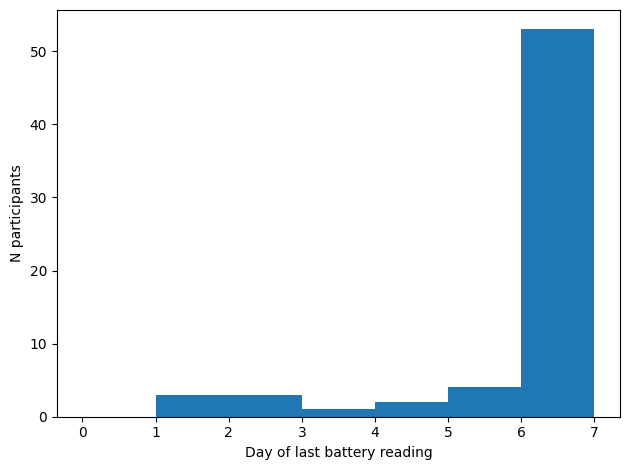

In [18]:
"""
Find the last recording day for each participant

"""
max_delta = battery_df.groupby("p_id")["delta"].max()

fig, axis = plt.subplots()
axis.hist(max_delta.dt.days, bins=range(8))
axis.set_xlabel("Day of last battery reading")
axis.set_ylabel("N participants")

fig.tight_layout()
fig.savefig(f"{imgdir}/last_battery_reading.png")

In [9]:
"""
Find the last entry day of each participant

"""
from ema import clean

# Read in meal entries
meal_df = clean.cleaned_smartwatch(keep_catchups=False)

# Remove the non-responses
meal_df = meal_df[meal_df["meal_type"] != "No response"]

# Find the last entry for each participant
last_entry = meal_df.groupby("p_id")["delta"].max()

/home/mh19137/seaco_malaysia/ema/clean.py:118: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Normal' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  copy.loc[start_time, col_name] = "Normal"
/home/mh19137/seaco_malaysia/ema/clean.py:189: UserWarning: Long catchup: not marking Meal at 2022-05-19 09:02:49 as catchup
  warnings.warn(


 Open ended catchup at 2022-02-11 20:02:05 ended by No response at 2022-02-12 08:02:11
 Open ended catchup at 2022-02-14 20:26:30 ended by No response at 2022-02-15 08:02:16
 Open ended catchup at 2022-04-19 08:01:14 ended by No catch-up at 2022-04-19 08:01:17
 Open ended catchup at 2022-06-27 15:53:14 ended by Catch-up start at 2022-06-27 15:54:06
 Open ended catchup at 2021-12-31 22:11:10 ended by No catch-up at 2022-01-01 08:01:15
 Open ended catchup at 2022-05-24 07:25:36 ended by Catch-up start at 2022-05-24 07:26:00
 Open ended catchup at 2022-03-21 08:01:57 ended by No catch-up at 2022-03-21 08:02:04
 Open ended catchup at 2022-03-07 18:33:30 ended by No catch-up at 2022-03-07 18:33:34
 Open ended catchup at 2022-03-07 18:37:08 ended by No catch-up at 2022-03-07 18:37:14
 Open ended catchup at 2022-03-07 19:29:23 ended by No response at 2022-03-08 08:02:56
 Open ended catchup at 2022-03-08 08:30:40 ended by No catch-up at 2022-03-08 08:31:08
 Open ended catchup at 2022-03-08 09:

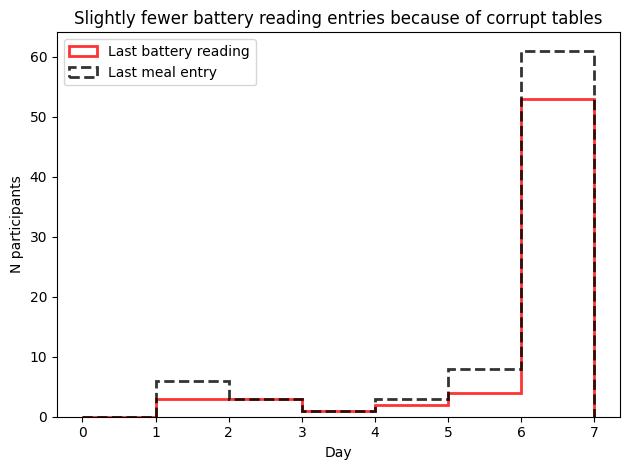

In [10]:
fig, axis = plt.subplots()

hist_kw = {"bins": range(8), "histtype": "step", "linewidth": 2, "alpha": 0.8}
axis.hist(max_delta, **hist_kw, color="r", label="Last battery reading")
axis.hist(
    last_entry.dt.days, **hist_kw, linestyle="--", color="k", label="Last meal entry"
)
axis.set_xlabel("Day")
axis.set_ylabel("N participants")
axis.legend()
axis.set_title("Slightly fewer battery reading entries because of corrupt tables")

fig.tight_layout()
fig.savefig(f"{imgdir}/last_meal_entry.png")

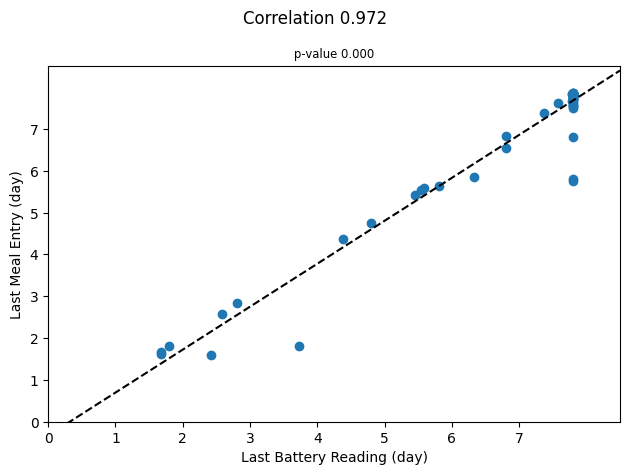

In [63]:
"""
Scatter plot showing the last meal entry vs last battery reading

"""
from scipy.stats import pearsonr

last_entry_df = (
    pd.DataFrame(max_delta)
    .merge(last_entry, on="p_id", how="left")
    .rename(columns={"delta_x": "last_battery", "delta_y": "last_entry"})
)

fig, axis = plt.subplots()
axis.scatter(
    last_entry_df["last_battery"].dt.total_seconds(),
    last_entry_df["last_entry"].dt.total_seconds(),
)

# Fit and plot a line
coefs = np.polyfit(
    last_entry_df["last_battery"].dt.total_seconds(),
    last_entry_df["last_entry"].dt.total_seconds(),
    1,
)
x_values = np.linspace(0, 8.5) * 24 * 3600
y_values = np.poly1d(coefs)(x_values)
axis.plot(x_values, y_values, "--", color="k")

axis.set_xticks(np.arange(8) * 24 * 3600, range(8))
axis.set_yticks(np.arange(8) * 24 * 3600, range(8))

axis.set_xlim(0, 8.5 * 24 * 3600)
axis.set_ylim(0, 8.5 * 24 * 3600)

axis.set_xlabel("Last Battery Reading (day)")
axis.set_ylabel("Last Meal Entry (day)")

# Calculate the Pearson correlation coefficient and the p-value
correlation, p_value = pearsonr(
    last_entry_df["last_battery"].dt.total_seconds(),
    last_entry_df["last_entry"].dt.total_seconds(),
)

fig.suptitle(f"Correlation {correlation:.3f}")
axis.set_title(f"p-value {p_value:.3f}", fontsize="small")

fig.tight_layout()
fig.savefig(f"{imgdir}/last_meal_vs_battery.png")

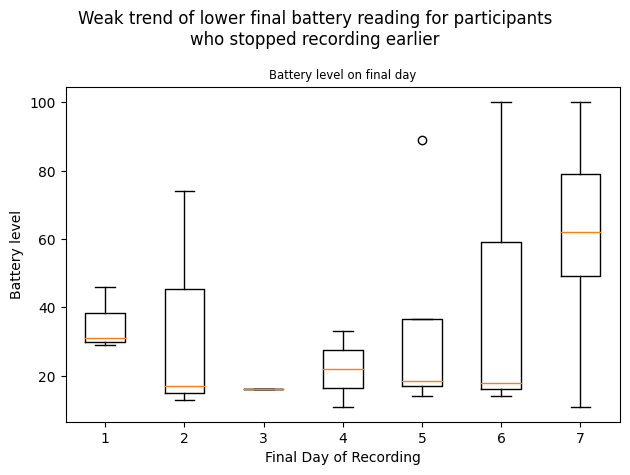

In [81]:
"""
Plot the battery level against final day

"""
fig, axis = plt.subplots()

deltas = []
battery_lvls = []
for _, group in battery_df.groupby("p_id"):
    row = group.loc[group["delta"].idxmax()]
    deltas.append(row["delta"].days)
    battery_lvls.append(row["battery_lvl"])

# Box plot for each day
for day in np.unique(deltas):
    axis.boxplot(
        [battery_lvls[i] for i, delta in enumerate(deltas) if delta == day],
        positions=[day],
        widths=0.5,
    )

axis.set_xlabel("Final Day of Recording")
axis.set_ylabel("Battery level")

axis.set_title("Battery level on final day", fontsize="small")
fig.suptitle(
    "Weak trend of lower final battery reading for participants\nwho stopped recording earlier"
)

fig.tight_layout()
fig.savefig(f"{imgdir}/final_battery_reading.png")

In [14]:
"""
Scatter plot showing number of entries per day vs battery level on that day, colour coded by day

"""
# Find the number of entries per day
# Find the average battery level per day
# Scatter plot, colour coded by day

'\nScatter plot showing number of entries per day vs battery level on that day, colour coded by day\n\n'